In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm 
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LogisticRegression

In [2]:
def factor_cat_features(df, feature):
    codes, uniques = pd.factorize(df[feature], sort=True)
    if -1 in codes:
        codes = codes + 1
        uniques = ['NaN'] + list(uniques)
    df[feature] = codes
    return df, len(uniques)

In [7]:
class Net(nn.Module):

    def __init__(self,cat_features_len,dropout_param=0.2):
        super(Net, self).__init__()
        self.fc = nn.Linear(5, 50)
        self.fc2 = nn.Linear(80, 2)
        self.embs = nn.ModuleList([nn.Embedding(i, 10) for i in cat_features_len])
        self.dropout = nn.Dropout(dropout_param)

    def forward(self, x,x_cat):
        cat_arr = []
        for i,emb in enumerate(self.embs):
            cat_arr.append(emb(x_cat[:,i]))
        x_emb = torch.cat(cat_arr, 1)
        x = F.relu(self.fc(x))
        x_concat = torch.cat((x_emb,x), 1)
        x_concat = self.dropout(x_concat)
        classifiaction_out = self.fc2(x_concat)    
        return classifiaction_out

In [104]:
def train_and_evaluate(other_flag=1):
    file_name_ref= 'corona_tested_individuals_ver_001.xlsx'
    df = pd.read_excel(file_name_ref)
    df = df[df['corona_result']!= 'אחר']
    df['corona_result'] = df['corona_result'].apply(lambda x:1 if x=='חיובי' else 0)
    df.drop(['test_date'],axis=1,inplace=True)
    df = df.fillna(value={'cough': 0, 'fever': 0, 'sore_throat': 0, 'shortness_of_breath': 0,'head_ache':0})
    if other_flag:
        df = df[df['test_indication']!='Other']
    cat_features = ['test_indication','gender','age_60_and_above']
    ord_features = ['cough','fever','sore_throat','shortness_of_breath','head_ache']
    cat_features_len = []
    for feat in cat_features:
        df, num_uniques = factor_cat_features(df, feat)
        cat_features_len.append(num_uniques)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_df,test_df = train_test_split(df,test_size=0.25,random_state=0)
    X_ord_train = torch.from_numpy(train_df[ord_features].values).double().to(device)
    X_ord_test = torch.from_numpy(test_df[ord_features].values).double().to(device)
    X_cat_train = torch.from_numpy(train_df[cat_features].values).long().to(device)
    X_cat_test = torch.from_numpy(test_df[cat_features].values).long().to(device)
    y_train = torch.from_numpy(train_df['corona_result'].values).long().to(device)
    y_test = torch.from_numpy(test_df['corona_result'].values).long().to(device)
    train_dataset = Data.TensorDataset(X_ord_train, X_cat_train, y_train)
    test_dataset = Data.TensorDataset(X_ord_test, X_cat_test, y_test)

    BATCH_SIZE = 256
    num_workers = 0
    train_loader = Data.DataLoader(
        dataset=train_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               # random shuffle for training
        num_workers=num_workers,              # subprocesses for loading data
    )
    test_loader = Data.DataLoader(
        dataset=test_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               # random shuffle for training
        num_workers=num_workers,              # subprocesses for loading data
    )
    if other_flag:
        n_epochs = 30
        lr = 0.001
        dropout = 0.2
        weights = [1, float(y_train.shape[0]) / float(y_train.sum())/2]
    else:
        n_epochs = 20
        lr = 0.00025
        dropout = 0.0
        weights = [1, float(y_train.shape[0]) / float(y_train.sum())]
    net = Net(cat_features_len, dropout_param=dropout)
    net = net.double()
    net = net.to(device)
    
    class_weights = torch.DoubleTensor(weights).cuda()
    
    loss_func = nn.CrossEntropyLoss(reduction='sum',weight=class_weights)
    optimizer = optim.Adam(net.parameters(), lr=lr,weight_decay=0.00005)
    for epoch in range(n_epochs):  
        running_loss = 0.0
        net.train()
        running_accu = 0.0
        for step, (b_x, b_x_cat, b_y) in tqdm(enumerate(train_loader)):  # for each training step
            classifiaction_out = net(b_x, b_x_cat)      # input x and predict based on x
            loss = loss_func(classifiaction_out, b_y)     # must be (1. nn output, 2. target)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step() 
            running_loss += loss.item()
            running_accu += (classifiaction_out.argmax(dim=1) == b_y).sum().item() 

        net.eval()
        running_test_loss = 0.0
        running_test_accu = 0.0
        for step, (b_x, b_x_cat, b_y) in tqdm(enumerate(test_loader)):
            y_pred = net(b_x, b_x_cat)
            test_loss = loss_func(y_pred, b_y)
            running_test_loss += test_loss.item()
            running_test_accu += (y_pred.argmax(dim=1) == b_y).sum().item()
        train_loss = running_loss / X_ord_train.size()[0]
        train_accu = running_accu / X_ord_train.size()[0]
        test_loss = running_test_loss / X_ord_test.size()[0]
        test_accu = running_test_accu / X_ord_test.size()[0]
        print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}, acc: {train_accu:.4f}, Test Loss:{test_loss:.4f} , Test Acc: {test_accu:.4f}')
    y_pred_test = net(X_ord_test, X_cat_test)
    y_pred_test = F.softmax(y_pred_test)
    y_pred_test = y_pred_test.argmax(dim=1)
    mat = confusion_matrix(y_test.cpu().numpy(),y_pred_test.cpu().numpy())
    recall = mat[1,1] / (mat[1,0] + mat[1,1])
    precision = mat[1,1] / (mat[0,1] + mat[1,1])
    print('recall:',recall,'precision:', precision)
    df_cm = pd.DataFrame(mat, range(2), range(2))
    sn.set(font_scale=1.0) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.5g') # font size
    plt.show()
    return net
    



Epoch: 00, Loss: 0.6586, acc: 0.6833, Test Loss:0.6061 , Test Acc: 0.7942



Epoch: 01, Loss: 0.5793, acc: 0.7896, Test Loss:0.5359 , Test Acc: 0.8189



Epoch: 02, Loss: 0.5241, acc: 0.8028, Test Loss:0.4871 , Test Acc: 0.8200



Epoch: 03, Loss: 0.4848, acc: 0.8093, Test Loss:0.4554 , Test Acc: 0.8232



Epoch: 04, Loss: 0.4658, acc: 0.8124, Test Loss:0.4385 , Test Acc: 0.8286



Epoch: 05, Loss: 0.4524, acc: 0.8200, Test Loss:0.4303 , Test Acc: 0.8294



Epoch: 06, Loss: 0.4447, acc: 0.8197, Test Loss:0.4254 , Test Acc: 0.8298



Epoch: 07, Loss: 0.4437, acc: 0.8227, Test Loss:0.4235 , Test Acc: 0.8314



Epoch: 08, Loss: 0.4423, acc: 0.8217, Test Loss:0.4220 , Test Acc: 0.8306



Epoch: 09, Loss: 0.4400, acc: 0.8234, Test Loss:0.4216 , Test Acc: 0.8302



Epoch: 10, Loss: 0.4400, acc: 0.8208, Test Loss:0.4208 , Test Acc: 0.8302



Epoch: 11, Loss: 0.4384, acc: 0.8242, Test Loss:0.4208 , Test Acc: 0.8302



Epoch: 12, Loss: 0.4373, acc: 0.8205, Test Loss:0.4208 , Test Acc: 0.8302



Epoch: 13, Loss: 0.4373, acc: 0.8257, Test Loss:0.4203 , Test Acc: 0.8294



Epoch: 14, Loss: 0.4399, acc: 0.8184, Test Loss:0.4198 , Test Acc: 0.8302



Epoch: 15, Loss: 0.4360, acc: 0.8261, Test Loss:0.4199 , Test Acc: 0.8302



Epoch: 16, Loss: 0.4369, acc: 0.8222, Test Loss:0.4194 , Test Acc: 0.8302



Epoch: 17, Loss: 0.4337, acc: 0.8264, Test Loss:0.4193 , Test Acc: 0.8302



Epoch: 18, Loss: 0.4378, acc: 0.8231, Test Loss:0.4193 , Test Acc: 0.8302



Epoch: 19, Loss: 0.4334, acc: 0.8214, Test Loss:0.4191 , Test Acc: 0.8302



Epoch: 20, Loss: 0.4343, acc: 0.8213, Test Loss:0.4187 , Test Acc: 0.8302



Epoch: 21, Loss: 0.4351, acc: 0.8188, Test Loss:0.4186 , Test Acc: 0.8302



Epoch: 22, Loss: 0.4344, acc: 0.8244, Test Loss:0.4189 , Test Acc: 0.8302



Epoch: 23, Loss: 0.4355, acc: 0.8241, Test Loss:0.4189 , Test Acc: 0.8302



Epoch: 24, Loss: 0.4360, acc: 0.8238, Test Loss:0.4184 , Test Acc: 0.8302



Epoch: 25, Loss: 0.4357, acc: 0.8214, Test Loss:0.4185 , Test Acc: 0.8302



Epoch: 26, Loss: 0.4326, acc: 0.8254, Test Loss:0.4186 , Test Acc: 0.8302



Epoch: 27, Loss: 0.4313, acc: 0.8259, Test Loss:0.4185 , Test Acc: 0.8302



Epoch: 28, Loss: 0.4347, acc: 0.8260, Test Loss:0.4185 , Test Acc: 0.8302



Epoch: 29, Loss: 0.4304, acc: 0.8241, Test Loss:0.4183 , Test Acc: 0.8302
recall: 0.8122448979591836 precision: 0.8298582151793161


C:\Users\Dima1\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


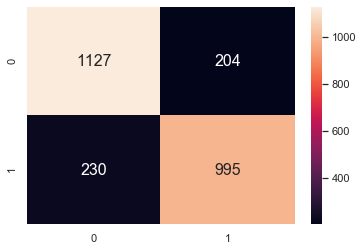

In [98]:
net = train_and_evaluate()


Epoch: 00, Loss: 1.0327, acc: 0.9172, Test Loss:0.8497 , Test Acc: 0.9165



Epoch: 01, Loss: 0.8009, acc: 0.9129, Test Loss:0.7370 , Test Acc: 0.9147



Epoch: 02, Loss: 0.7422, acc: 0.9130, Test Loss:0.7074 , Test Acc: 0.9145



Epoch: 03, Loss: 0.7227, acc: 0.9132, Test Loss:0.6943 , Test Acc: 0.9190



Epoch: 04, Loss: 0.7132, acc: 0.9160, Test Loss:0.6884 , Test Acc: 0.9188



Epoch: 05, Loss: 0.7085, acc: 0.9159, Test Loss:0.6850 , Test Acc: 0.9174



Epoch: 06, Loss: 0.7059, acc: 0.9156, Test Loss:0.6833 , Test Acc: 0.9174



Epoch: 07, Loss: 0.7040, acc: 0.9154, Test Loss:0.6822 , Test Acc: 0.9173



Epoch: 08, Loss: 0.7031, acc: 0.9155, Test Loss:0.6819 , Test Acc: 0.9188



Epoch: 09, Loss: 0.7026, acc: 0.9155, Test Loss:0.6809 , Test Acc: 0.9174



Epoch: 10, Loss: 0.7021, acc: 0.9159, Test Loss:0.6805 , Test Acc: 0.9173



Epoch: 11, Loss: 0.7019, acc: 0.9153, Test Loss:0.6802 , Test Acc: 0.9174



Epoch: 12, Loss: 0.7015, acc: 0.9165, Test Loss:0.6815 , Test Acc: 0.9172



Epoch: 13, Loss: 0.7016, acc: 0.9163, Test Loss:0.6801 , Test Acc: 0.9183



Epoch: 14, Loss: 0.7010, acc: 0.9166, Test Loss:0.6798 , Test Acc: 0.9172



Epoch: 15, Loss: 0.7010, acc: 0.9171, Test Loss:0.6799 , Test Acc: 0.9173



Epoch: 16, Loss: 0.7011, acc: 0.9169, Test Loss:0.6800 , Test Acc: 0.9172



Epoch: 17, Loss: 0.7007, acc: 0.9173, Test Loss:0.6804 , Test Acc: 0.9182



Epoch: 18, Loss: 0.7007, acc: 0.9175, Test Loss:0.6796 , Test Acc: 0.9199



Epoch: 19, Loss: 0.7005, acc: 0.9173, Test Loss:0.6793 , Test Acc: 0.9199
recall: 0.7792527040314651 precision: 0.5099742599742599


C:\Users\Dima1\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


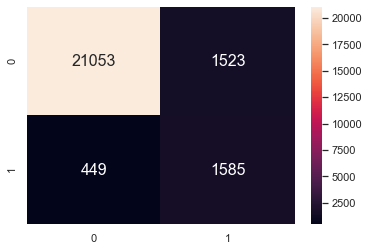

In [105]:
net2 = train_and_evaluate(other_flag=0)

# Logistic regression

In [99]:
def train_and_evaluate_log_reg(other_flag=1):
    file_name_ref= 'corona_tested_individuals_ver_001.xlsx'
    df = pd.read_excel(file_name_ref)
    df = df[df['corona_result']!= 'אחר']
    df['corona_result'] = df['corona_result'].apply(lambda x:1 if x=='חיובי' else 0)
    df.drop(['test_date'],axis=1,inplace=True)
    df = df.fillna(value={'cough': 0, 'fever': 0, 'sore_throat': 0, 'shortness_of_breath': 0,'head_ache':0})
    if other_flag:
        df = df[df['test_indication']!='Other']
    cat_features = ['test_indication','gender','age_60_and_above']
    ord_features = ['cough','fever','sore_throat','shortness_of_breath','head_ache']
    df_cat = pd.get_dummies(df[cat_features], dummy_na=True)
    cat_new_features = list(df_cat.columns)
    df_tot = pd.concat((df[ord_features],df_cat,df['corona_result']),axis=1)
    train_df,test_df = train_test_split(df_tot,test_size=0.25,random_state=0)
    X_train = train_df[cat_new_features + ord_features].values
    X_test = test_df[cat_new_features + ord_features].values
    y_train = train_df['corona_result'].values
    y_test = test_df['corona_result'].values
    weights = {0:1, 1:float(y_train.shape[0]) / float(y_train.sum())/2}
    clf = LogisticRegression(random_state=0,class_weight = 'balanced')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    mat = confusion_matrix(y_test,y_pred)
    recall = mat[1,1] / (mat[1,0] + mat[1,1])
    precision = mat[1,1] / (mat[0,1] + mat[1,1])
    print('recall:',recall,'precision:', precision)

    df_cm = pd.DataFrame(mat, range(2), range(2))
    sn.set(font_scale=1.0) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.5g') # font size
    plt.show()

recall: 0.8146938775510204 precision: 0.82411230388109


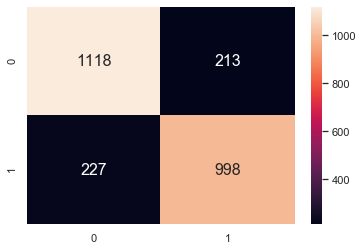

In [100]:
train_and_evaluate_log_reg(other_flag=1)

recall: 0.7753195673549655 precision: 0.5110174983797796


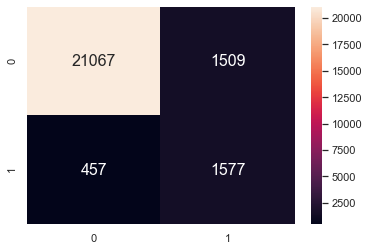

In [101]:
train_and_evaluate_log_reg(other_flag=0)